#HW 10 CLUSTERING BUSINESS

#cluster time trends in NYC businesses: 
#DATA
#Census Business data:
##download census data for businesses by ZIP code. the data is here
http://www.census.gov/econ/cbp/download/
##and it can be downloaded by hand. you can also download it with 3 terminal commands as follows: the data from 1993 through 2001 is different in the format of its path than the data after 2001 (that is why more than one for loop is needed)



for ((y=93; y<=99; y+=1)); do wget ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp$y\totals.zip; done

for ((y=0; y<=9; y+=1)); do wget ftp://ftp.census.gov/econ200$y\/CBP_CSV/zbp0$y\totals.zip; done

for ((y=10; y<=15; y+=1)); do wget ftp://ftp.census.gov/econ20$y\/CBP_CSV/zbp$y\totals.zip; done

#NYC zip codes shape file is here
##http://data.nycprepared.org/dataset/nyc-zip-code-tabulation-areas/resource/0c0e14e9-78e1-404e-97b0-c2fabceb3981


NOTES: 
to read in a zip file without unzipping it you can use the pandas and zipfile packages

## Task1: get and prep your data

In [9]:
import numpy as np
import pandas as pd

In [1]:
import json
import urllib2
url = 'https://nycdatastables.s3.amazonaws.com/2013-08-19T18:18:28.877Z/nyc-zip-code-tabulation-areas-polygons.geojson'
request = urllib2.urlopen(url)
zipcodejsonfile = json.load(request)

In [2]:
zipcode = []
for feature in zipcodejsonfile['features']:
    zipc = int(feature['properties']["postalCode"])
    zipcode.append(zipc)

In [3]:

import zipfile #i am not giving it a name cause i intend to use it only once

In [4]:
# Open and read the zip files
Total_Data = pd.DataFrame({'zip':zipcode})
for i in range(1994,2014):
    if i >= 1998 and i <= 2002:  # column has upper case
        j = i%100
        if j < 10:      # get the last two digit; 
            j = '0{0}'.format(j)
        fname = 'zbp{0}totals.zip'.format(j)
        zf = zipfile.ZipFile(fname)
        df1 = pd.read_csv(zf.open(fname.replace('.zip','.txt')))
        df1.columns = ['zip', 'name','empflag','emp','qp1','ap','est']
    else:
        j = i%100
        if j < 10:
            j = '0{0}'.format(j)
        fname = 'zbp{0}totals.zip'.format(j)
        zf = zipfile.ZipFile(fname)
        df1 = pd.read_csv(zf.open(fname.replace('.zip','.txt')))
    # Get information from the files
    df2 = df1[df1['zip'].isin(zipcode)]
    df3 = pd.DataFrame({'zip':df2['zip'],'est':df2['est']})
    Total_Data = pd.merge(Total_Data,df3,on=['zip'])

In [5]:
Total_Data = Total_Data.set_index(['zip'])

In [6]:
Total_Data.head()

,est_x,est_y,est_x,est_y,est_x,est_y,est_x,est_y,est_x,est_y,est_x,est_y,est_x,est_y,est_x,est_y,est_x,est_y,est_x,est_y
zip,,,,,,,,,,,,,,,,,,,,
11372,1229,1236,1292,1309,1351,1376,1409,1408,1463,1521,1554,1539,1527,1545,1538,1572,1629,1647,1724,1759
11004,194,188,176,192,194,186,189,204,214,228,226,225,226,238,227,233,229,222,241,241
11040,1422,1414,1335,1344,1344,1350,1350,1341,1398,1403,1406,1441,1454,1488,1503,1475,1494,1488,1510,1539
11426,326,219,209,198,203,217,213,217,207,211,221,226,226,228,226,237,248,256,266,258
11365,492,476,483,522,509,519,553,574,574,582,599,604,608,617,616,628,643,677,679,714


you may need to clean your data: for some NYC zip codes there may be no info
    
sanity check: you should have 20 (Ntimestamps) datapoints per time series and about 250 zipcodes (Nzipcodes)

In [10]:
def canconvert(mydata):
    try :
        float(mydata)
        return True
    except ValueError:
        return False

In [11]:
vfunc = np.vectorize(canconvert)
indx = vfunc(np.array(Total_Data))
Total_Data[~indx] = float('NaN') 

In [12]:
Total_Data.head()

,est_x,est_y,est_x,est_y,est_x,est_y,est_x,est_y,est_x,est_y,est_x,est_y,est_x,est_y,est_x,est_y,est_x,est_y,est_x,est_y
zip,,,,,,,,,,,,,,,,,,,,
11372,1229,1236,1292,1309,1351,1376,1409,1408,1463,1521,1554,1539,1527,1545,1538,1572,1629,1647,1724,1759
11004,194,188,176,192,194,186,189,204,214,228,226,225,226,238,227,233,229,222,241,241
11040,1422,1414,1335,1344,1344,1350,1350,1341,1398,1403,1406,1441,1454,1488,1503,1475,1494,1488,1510,1539
11426,326,219,209,198,203,217,213,217,207,211,221,226,226,228,226,237,248,256,266,258
11365,492,476,483,522,509,519,553,574,574,582,599,604,608,617,616,628,643,677,679,714


IMPORTANT: we talked about the importance of "whitening" your data: dividing each feature by its standard deviation. 
Whitenings decorrelates the data: it makes the features independent so that the data covariance matrix is the identity matrix.
Whitening your data in time series analysis is in most cases **wrong**: you are modifying your time behaviour. This is because of the strong correlation between features (two consecutive time stamps for the same observation, the same zip code here, are strongly correlated). Here instead you want to standardize your time series: subtract the mean and divide each time series (separately) by its standard deviation. As a sanity check (if you use skitlearn Kmeans or skitlearns kmeans2): you want your data array to be shaped Nzipcodes x Ntimestamps

mydata.shape should be (Nzipcodes, Ntimestamps)

mydata[i].std() shoould be 1 for all i in range(len(Nzipcodes))

mydata[i].mean() should be ~0 for all i in range(len(Nzipcodes))



In [13]:
Total_Data.shape[1]

20

In [14]:
# Standardize the time series
for i in range(Total_Data.shape[0]):
    Total_Data.iloc[i] = (Total_Data.iloc[i] - Total_Data.iloc[i].mean())/Total_Data.iloc[i].std()

TASKS:
    
    1. get and prep your data.
    2. cluster the time series with K-means in **a few** clusters (as discussed there is no real good, sound way to decide what a good number is here. try a few options, keeping in mind a few is more than a couple, but i recommand you stay within the single digit numbers)
    3. plot the cluster centers (if you used K means those are the means of the clusters). you can plot for example the cluster centers overlayed on each time series (using the alpha channel to control the opacity in the plot may be helpful here).
    4. Use another clustering algorithm (of your choice)
    5. overlay your data on a NYC map: you can use shapefiles for the zip codes and different colors for different clusters
    6. Compare the results of the 2 algorithms
    7. attempt an interpretation. this is dangerous ground: clustering is an exploratory tool so you do not want to jump to conclusions because you see some clusters! but seeing structure in your data can inform your next moves as an investigator. 
    

## Task2: Cluster the time series

In [15]:
import sklearn.cluster
from scipy.cluster.vq import kmeans2
import matplotlib.pyplot as plt
% matplotlib inline

In [16]:
# t1,t2 are two time series (panda series type)
import math
def euclid_dist(t1,t2):
    return math.sqrt(sum((t1-t2)**2))

In [18]:
# create a list of timeseries for all the zip codes
timeseries_list = []
for i in range(Total_Data.shape[0]):
    timeseries_list.append(np.array(Total_Data.iloc[i]))

In [19]:
# Reference from https://github.com/alexminnaar/time-series-classification-and-clustering/blob/master/Time%20Series%20Classification%20and%20Clustering.ipynb
import random

def k_means_clust(data,num_clust,num_iter):
    centroids=random.sample(data,num_clust)
    counter=0
    for n in range(num_iter):
        counter+=1
        #print counter
        assignments={}
        #assign data points to clusters
        for ind,i in enumerate(data):
            min_dist=float('inf')  # initial distance set to infinitive
            closest_clust=None
            for c_ind,j in enumerate(centroids): # Calculate the distance between a given point and a centroid
                if euclid_dist(i,j)<min_dist:
                    min_dist=euclid_dist(i,j) # Update the minumum distance
                    closest_clust=c_ind
            if closest_clust in assignments:
                assignments[closest_clust].append(ind) # Assign the index of the clustered data into the centroids index
            else:
                assignments[closest_clust]=[]
    
        #recalculate centroids of clusters
        for key in assignments:  # Get the key of the assignment dictionary
            clust_sum=0
            for k in assignments[key]: # k is the index of the clustered data
                clust_sum=clust_sum+data[k]  #
            centroids[key]=[m/len(assignments[key]) for m in clust_sum]
    
    return centroids
        

In [20]:
# Get the zip codes in each cluster
def clusters(data,centroids,num_clust,num_iter):
    counter=0
    for n in range(num_iter):
        counter+=1
        #print counter
        assignments={}
        #assign data points to clusters
        for ind,i in enumerate(data):
            min_dist=float('inf')  # initial distance set to infinitive
            closest_clust=None
            for c_ind,j in enumerate(centroids): # Calculate the distance between a given point and a centroid
                if euclid_dist(i,j)<min_dist:
                    min_dist=euclid_dist(i,j) # Update the minumum distance
                    closest_clust=c_ind
            if closest_clust in assignments:
                assignments[closest_clust].append(ind) # Assign the index of the clustered data into the centroids index
            else:
                assignments[closest_clust]=[]
    return assignments

## Task3: Plot the cluster centers

### Number of clusters = 2

In [21]:
centroids = k_means_clust(timeseries_list,2,10)
assignments = clusters(timeseries_list,centroids,2,10)

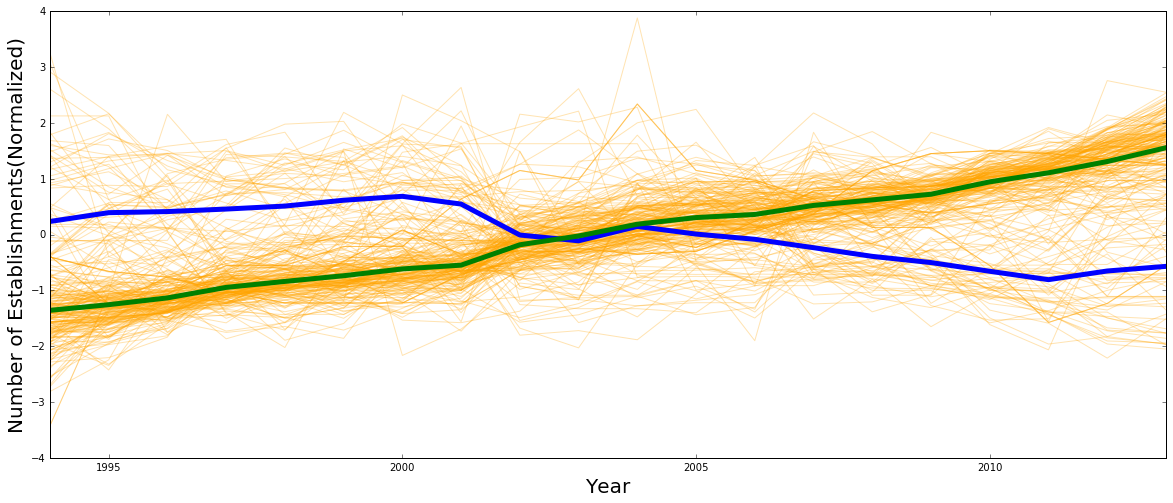

In [22]:
fig = plt.figure(figsize=(20,8))
for i in range(Total_Data.shape[0]):
    plt.plot(np.arange(1994,2014,1),np.array(Total_Data.iloc[i]),'orange',alpha=0.3)
    plt.xlim(1994,2013)
# Visualize the cluster centers
for i in centroids:
    plt.plot(np.arange(1994,2014,1),i,lw=5)
plt.xlabel("Year", fontsize=20)
plt.ylabel("Number of Establishments(Normalized)", fontsize=20)

### Number of clusters = 3

In [84]:
centroids = k_means_clust(timeseries_list,3,100)
assignments = clusters(timeseries_list,centroids,3,100)

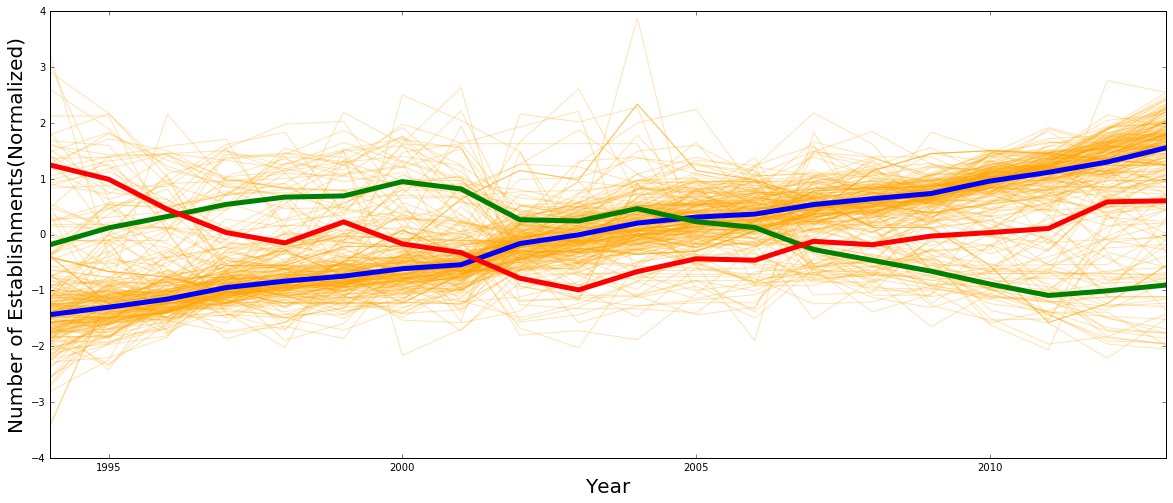

In [85]:
fig = plt.figure(figsize=(20,8))
for i in range(Total_Data.shape[0]):
    plt.plot(np.arange(1994,2014,1),np.array(Total_Data.iloc[i]),'orange',alpha=0.3)
    plt.xlim(1994,2013)
# Visualize the cluster centers
for i in centroids:
    plt.plot(np.arange(1994,2014,1),i,lw=5)
plt.xlabel("Year", fontsize=20)
plt.ylabel("Number of Establishments(Normalized)", fontsize=20)

### Number of clusters = 4

In [25]:
centroids = k_means_clust(timeseries_list,4,10)
assignments = clusters(timeseries_list,centroids,4,10)

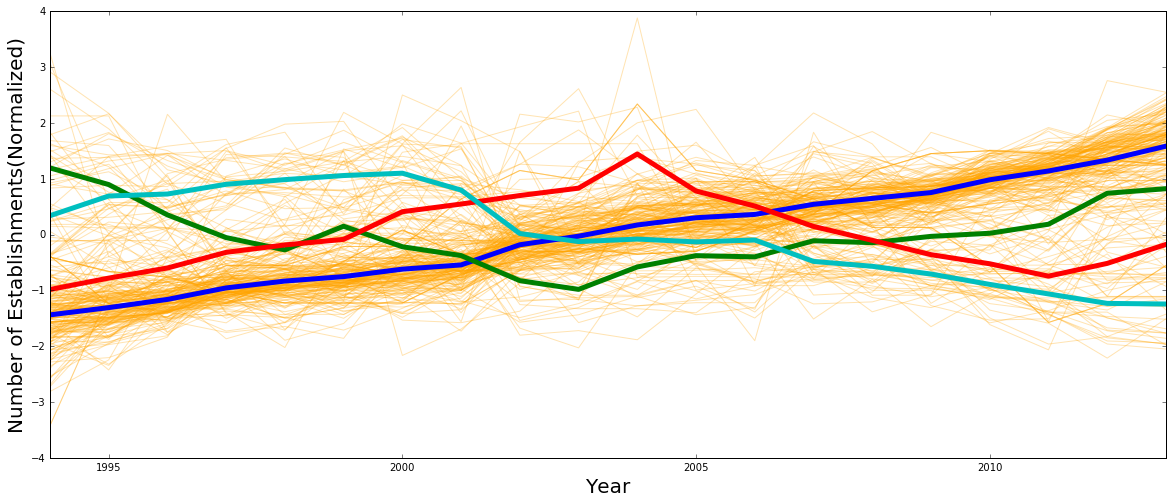

In [26]:
fig = plt.figure(figsize=(20,8))
for i in range(Total_Data.shape[0]):
    plt.plot(np.arange(1994,2014,1),np.array(Total_Data.iloc[i]),'orange',alpha=0.3)
    plt.xlim(1994,2013)
# Visualize the cluster centers
for i in centroids:
    plt.plot(np.arange(1994,2014,1),i,lw=5)
plt.xlabel("Year", fontsize=20)
plt.ylabel("Number of Establishments(Normalized)", fontsize=20)

### Plot each cluster center on top of all the timeseries which belong to the cluster center; 
#### Using 3 clusters

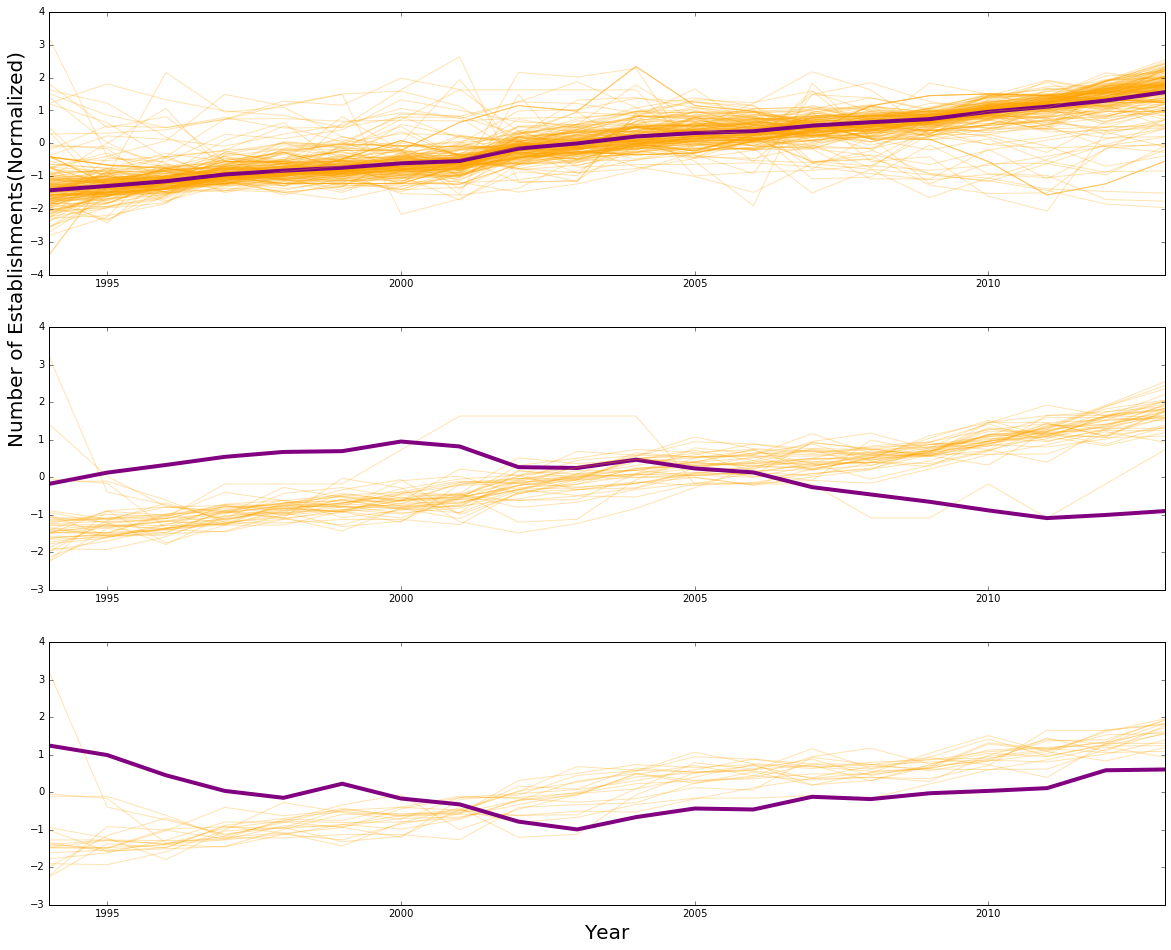

In [86]:
fig = plt.figure(figsize=(20,16))
# Visualize the cluster centers
for index,i in enumerate(centroids):
    for j in range(0,len(assignments[index])):  # loop over the zipcodes which belong to the first cluster to plot
        ax.plot(np.arange(1994,2014,1),np.array(Total_Data.iloc[j]),'orange',alpha=0.3)
        ax = fig.add_subplot(len(centroids),1,index+1)
    ax.plot(np.arange(1994,2014,1),i,'purple',lw=4) # plot the cluster center 
    ax.set_xlim(1994,2013)
ax.set_xlabel("Year", fontsize=20)
ax.set_ylabel("Number of Establishments(Normalized)", fontsize=20)
ax.yaxis.set_label_coords(-0.02, 2.5)

## Task4: Use another clustering algorithm

In [45]:
# Use hierarcical clustering
from scipy.cluster.hierarchy import dendrogram, linkage
#Z = linkage(timeseries_list,metric='euclidean')
Z = linkage(timeseries_list,'ward')

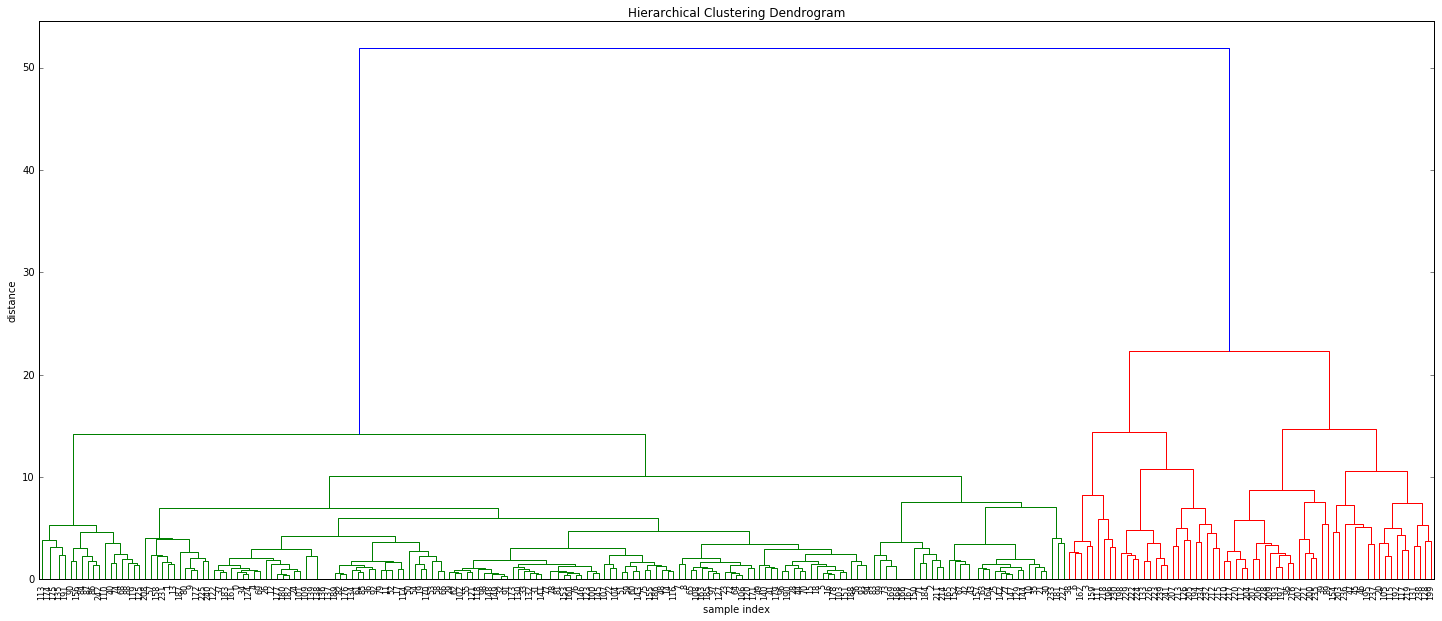

In [93]:
# Plot dendrogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    #truncate_mode='lastp',  # show only the last p merged clusters
    #p=12,  # show only the last p merged clusters
    leaf_font_size=8.,  # font size for the x axis labels
    #show_contracted=True
)
plt.show()

In [107]:
from scipy.cluster.hierarchy import fcluster
max_d = 13 # Set the distance threshold level
h_clusters = fcluster(Z, max_d, criterion='distance')

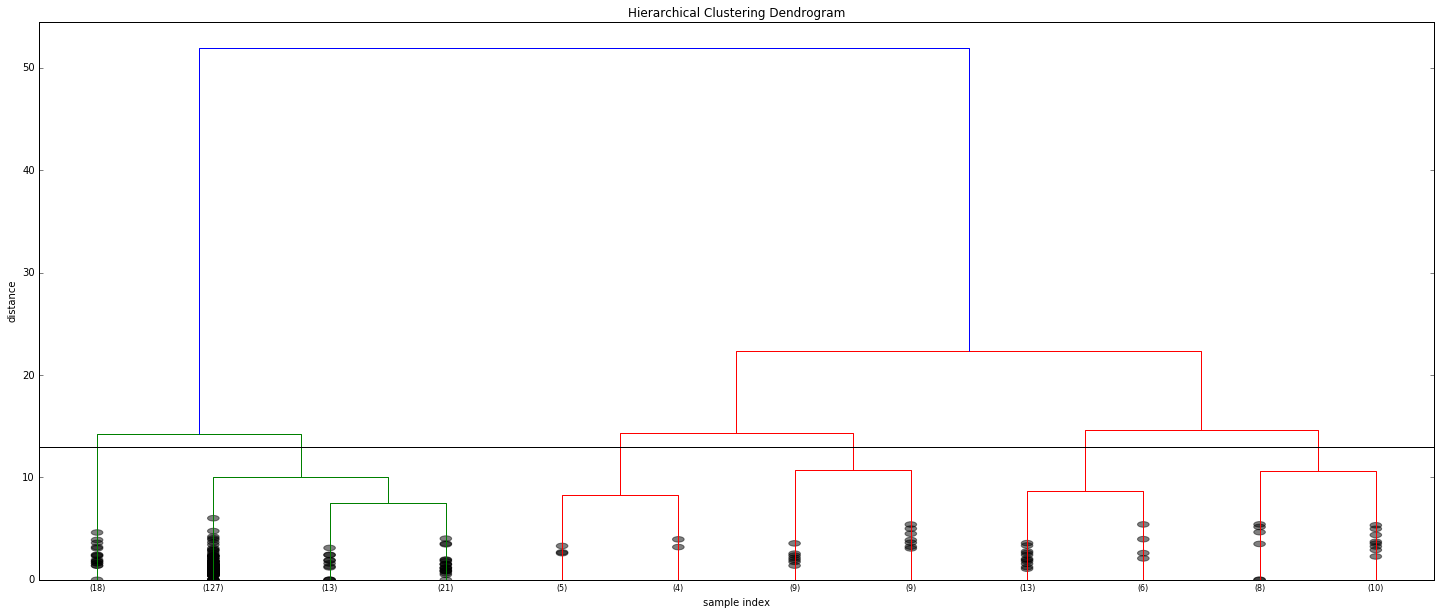

In [108]:
# show truncated dendrogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=12,  # show only the last p merged clusters
    leaf_font_size=8.,  # font size for the x axis labels
    show_contracted=True
)
plt.axhline(y=max_d, c='k')
plt.show()

In [109]:
# Get the unique value from the list of clusters
h_clusters_values = list(set(h_clusters))

In [110]:
print h_clusters_values

[1, 2, 3, 4, 5, 6]


In [111]:
# Find the zipcode index for all the clusters and put it in a dictionary
h_assignments={}
for value in h_clusters_values:
    h_assignments[value]=[i for i, j in enumerate(h_clusters) if j == value] # given a cluster number, find its corresponding zipcode index

## Task5: Overlay data on a NYC map: use shapefiles for the zip codes and different colors for different clusters

In [33]:
# Create an array to store all the zip codes info
zipcodearray = np.array(Total_Data.index)

In [98]:
# Extract the zip codes for all clusters
cluster_zipcode = []
for key in assignments:  # iterate over all the clusters value
    zipc_index = assignments[key] # get the zipcode index in each cluster
    one_cluster_zipc = list(set([zipcodearray[i] for i in zipc_index])) # get the zipcode based on its index for each cluster
    cluster_zipcode.append(one_cluster_zipc) # get the zipcode for all the clusters

In [99]:
len(cluster_zipcode)

3

In [100]:
# Given a zip code, find out which cluster it belongs to
def which_cluster(zipcode):
    if zipcode in h_cluster_zipcode[0]:
        return 0
    elif zipcode in h_cluster_zipcode[1]:
        return 1
    elif zipcode in h_cluster_zipcode[2]:
        return 2
    else:
        return 3

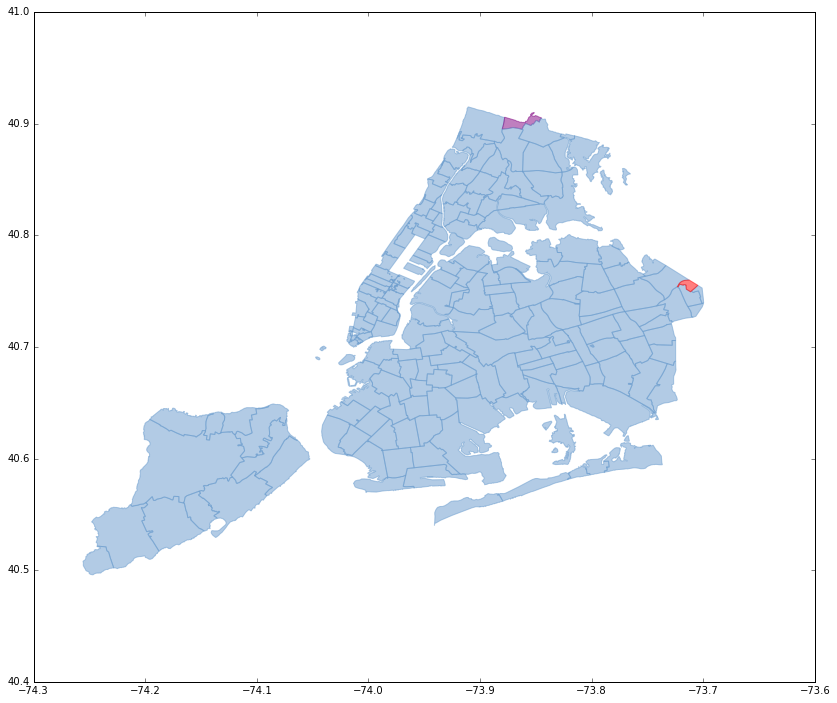

In [101]:
# Plot the cluster centers on top of the zipcode map
from descartes import PolygonPatch
fig = plt.figure(figsize=(25,12)) 
ax = fig.gca() 
patch_color =['#6699cc','#ff0000','#800080','#ffff00'] # Blue,Red,Purple,Yellow color for each cluster
GRAY = '#808080'
for feature in zipcodejsonfile['features']:
    poly = feature['geometry']
    zip_ = int(feature['properties']["postalCode"])
    # Plot the zipcode map
    #ax.add_patch(PolygonPatch(poly, fc=GRAY, ec=GRAY, alpha=0.5, zorder=2 ))
    # Plot the clusters
    if which_cluster(zip_) < 3: # if the zip code is in one of the clusters
        cluster_number = which_cluster(zip_)
        ax.add_patch(PolygonPatch(poly, fc=patch_color[cluster_number], ec=patch_color[cluster_number], alpha=0.5, zorder=2 ))
ax.axis('scaled')
plt.show()

In [113]:
# Extract the zip codes for all hierarchical clusters
h_cluster_zipcode = []
for key in h_assignments:  # iterate over all the clusters value
    h_zipc_index = h_assignments[key] # get the zipcode index in each cluster
    h_one_cluster_zipc = list(set([zipcodearray[i] for i in h_zipc_index])) # get the zipcode based on its index for each cluster
    h_cluster_zipcode.append(h_one_cluster_zipc) # get the zipcode for all the clusters

In [130]:
# Given a zip code, find out which cluster it belongs to
def which_h_cluster(zipcode):
    which_cluster = 0
    for i in range(len(h_cluster_zipcode)):
        if zipcode in h_cluster_zipcode[i]:
            which_cluster = i
    return which_cluster

In [131]:
which_h_cluster(10278)

1

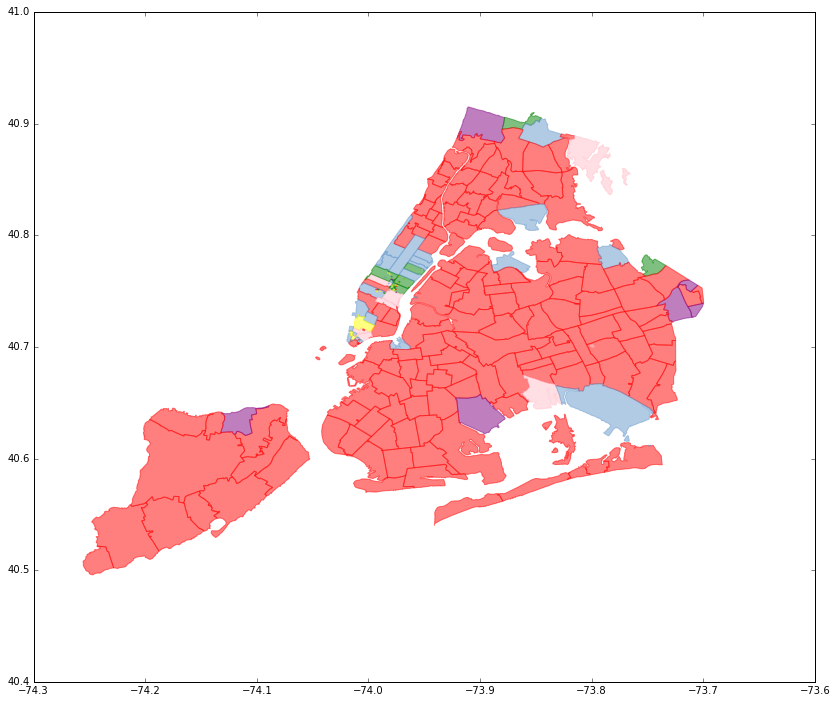

In [132]:
# Plot the cluster centers on top of the zipcode map
from descartes import PolygonPatch
fig = plt.figure(figsize=(25,12)) 
ax = fig.gca() 
patch_color =['#6699cc','#ff0000','#800080','#ffff00','#008000','#ffc0cb'] # Blue,Red,Purple,Yellow,Green,Pink color for each cluster
GRAY = '#808080'
for feature in zipcodejsonfile['features']:
    poly = feature['geometry']
    zip_ = int(feature['properties']["postalCode"])
    # Plot the zipcode map
    #ax.add_patch(PolygonPatch(poly, fc=GRAY, ec=GRAY, alpha=0.5, zorder=2 ))
    # Plot the clusters
    if which_h_cluster(zip_) < len(h_cluster_zipcode)+1: # if the zip code is in one of the clusters
        cluster_number = which_h_cluster(zip_)
        ax.add_patch(PolygonPatch(poly, fc=patch_color[cluster_number], ec=patch_color[cluster_number], alpha=0.5, zorder=2 ))
ax.axis('scaled')
plt.show()

## Task6: Compare the results of the 2 algorithms

K-means clustering gives a single set of clusters each time so multiple attemps of using different cluster numbers are needed to deternmine the number of clusters. Hierarchical clustering gives multiple set of clusters but an arbitrary distance level needs to be chose to determine the number of clusters.

K-means result shows that 2 to 3 clusters can show the general pattern of the timeseries similarities.
Hierarchical clustering shows that 3 or 6 clusters are good enough to classify all the timeseries.

## Task7: Interpretation

The majority of areas in New York City have similar time trend of number of business establishments which are growing over time from 1994 to 2013. For the areas showing different trends from the majority, they are at the periphery of cities. So their bad/uncentered locations might give rise to their shrinking number of business establishments.